# <font color = green> PROCESSAMENTO DE IMAGENS BIOMÉDICAS </font>

In [81]:
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np

import pydicom
from pydicom.data import get_testdata_files
from pydicom.data.data_manager import get_files

from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


## <font color = green> TESTANDO A LIB PYDICOM </font>

In [60]:
# Para abrir apenas uma imagem DICOM, podemos utilizar o get_files 
# path = "CINTILOGRAFIAS/BMT/P1A"
# dicom = "D405923.dcm"
# filename = get_files(path, dicom)[0]

In [61]:
# Le e retorna um dataset
# ds = pydicom.dcmread(filename)

In [62]:
# ds.PatientName

In [63]:
# ds

In [64]:
# Para verificarmos  a matriz da imagem utilizamos o pixel_array
# ds.pixel_array

## <font color = green> ABERTURA DAS IMAGENS </font>

### Salvando a matriz das imagens em duas listas que representam as classes 

In [65]:
bmt = []
graves = []

paths = glob.glob("CINTILOGRAFIAS/BMT/P*A/*.dcm")
for path in paths:
    dataset = pydicom.dcmread(path)
    bmt.append(dataset.pixel_array)
    
paths = glob.glob("CINTILOGRAFIAS/GRAVES/P*A/*.dcm")
for path in paths:
    dataset = pydicom.dcmread(path)
    graves.append(dataset.pixel_array)

### Visualizacao

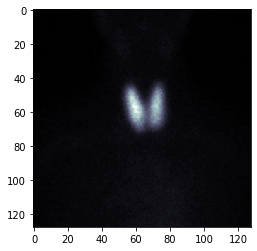

In [66]:
plt.imshow(graves[0], cmap=plt.cm.bone) 

### Salvando a imagem em JPG

In [67]:
# plt.imsave('bmt06.png', bmt[6])

## <font color = green> PRÉ-PROCESSAMENTO </font>

### Segmentacao da regiao de interesse
#### Como todas as imagens possuem tamanho padrão de 128x128 o corte será realizado no centro da imagem. O slice começará no pixel 32 e terminará no 96, para ambas as dimensões. 

In [68]:
# Graves
for index, image in enumerate(graves):
    # Calculando o tamanho da nova imagem
    altura, largura = int((image.shape[1]) / 2), int((image.shape[0]) / 2)
    inicio = int(altura/2)
    fim = int((image.shape[0]) - inicio)
    
    # Realizando o corte
    cropped_image = image[inicio:fim, inicio:fim]
    
    # Salvando a nova imagem no vetor
    graves[index] = cropped_image

# BMT
for index, image in enumerate(bmt):
    # Calculando o tamanho da nova imagem
    altura, largura = int((image.shape[1]) / 2), int((image.shape[0]) / 2)
    inicio = int(altura/2)
    fim = int((image.shape[0]) - inicio)
    
    # Realizando o corte
    cropped_image = image[inicio:fim, inicio:fim]
    
    # Salvando a nova imagem no vetor
    bmt[index] = cropped_image

### Reducao de ruído

In [69]:
# Graves
for index, image in enumerate(graves):
    graves[index] = cv2.GaussianBlur(image, (5,5), 0)
    plt.imsave('pos-processamento/grave' + str(index) + '.jpg', graves[index], cmap='gray')

# BMT
for index, image in enumerate(bmt):
    bmt[index] = cv2.GaussianBlur(image, (5,5), 0)
    plt.imsave('pos-processamento/bmt' + str(index) + '.jpg', bmt[index], cmap='gray')

## <font color = green> HISTOGRAMA </font>

#### Intensidade do maior pixel da imagem

In [70]:
# for index, image in enumerate(graves):
#     print(graves[index].max())

### Um histograma por classe
#### cv2.calcHist (image, channel, mask, histSize, histRange)

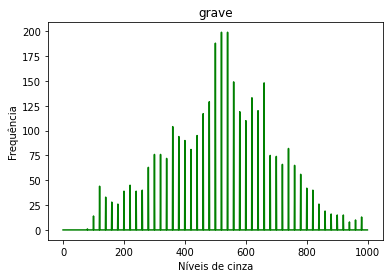

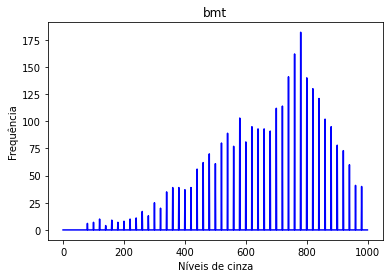

In [71]:
hist_graves = cv2.calcHist (graves, [0], None, [1000], [0, 50])
hist_bmt = cv2.calcHist (bmt, [0], None, [1000], [0, 50])

plt.figure()
plt.title('grave')
plt.xlabel("Níveis de cinza")
plt.ylabel("Frequência")
plt.plot(hist_graves, color = 'green')  
plt.savefig('histogramas/grave_class.png')

plt.figure()
plt.title('bmt')
plt.xlabel("Níveis de cinza")
plt.ylabel("Frequência")
plt.plot(hist_bmt, color = 'blue')  
plt.savefig('histogramas/bmt_class.png')

### Comparando os dois histogramas

In [72]:
compare = cv2.compareHist(hist_graves, hist_bmt, cv2.HISTCMP_CORREL)

In [73]:
compare

0.7272861074548204

## <font color = green> SEGMENTAÇÃO E CONTORNO </font>

In [74]:
# Graves
print("\nGRAVE")
for index, image in enumerate(graves):
    # Threshold
    thresh = cv2.threshold(graves[index], 100, 200, cv2.THRESH_BINARY)[1]
    thresh = thresh.astype(np.uint8)
    plt.imsave('segmentacao/graves' + str(index) + '.jpg', thresh, cmap='gray')
    
    # Contours
    cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    image_copy = graves[index].copy()
    cnt_image = cv2.drawContours(image=image_copy, contours=cnt, contourIdx=-1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    plt.imsave('contorno/graves' + str(index) + '.jpg', cnt_image, cmap=plt.cm.bone)
    
    print("Imagem:", index)
    print("Número de objetos:",  len(cnt))
    
    # Area
    if len(cnt) > 0:
        cnt = cnt[0]
        area = cv2.contourArea(cnt)
        print("Área:", area, "\n")
    else:
        print (0.0)

# BMT
print("\nBMT")
for index, image in enumerate(bmt):
    # Threshold
    thresh = cv2.threshold(bmt[index], 130, 200, cv2.THRESH_BINARY)[1]
    thresh = thresh.astype(np.uint8)
    plt.imsave('segmentacao/bmt' + str(index) + '.jpg', thresh, cmap='gray')
        
    # Contours
    cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    image_copy = bmt[index].copy()
    cnt_image = cv2.drawContours(image=image_copy, contours=cnt, contourIdx=-1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    plt.imsave('contorno/bmt' + str(index) + '.jpg', cnt_image, cmap=plt.cm.bone)
    
    print("Imagem:", index)
    print("Número de objetos:",  len(cnt))
    
    # Area
    if len(cnt) > 0:
        cnt = cnt[0]
        area = cv2.contourArea(cnt)
        print("Área:", area, "\n")
    else:
        print("Área:", 0.0, "\n")


GRAVE


error: OpenCV(4.5.1) /tmp/pip-req-build-n_alixql/opencv/modules/imgproc/src/drawing.cpp:2501: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


## <font color = green> Extração de Características </font>

In [ ]:
def calcula_contorno(images):
    areas = []
    objetos = []
    for image in images:
        # Threshold
        thresh = cv2.threshold(image, 130, 200, cv2.THRESH_BINARY)[1]
        thresh = thresh.astype(np.uint8)
            
        # Contours
        cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
       
        # Area
        if len(cnt) > 0:
            cnt = cnt[0]
            area = cv2.contourArea(cnt)

        else:
            area = 0.0

        areas.append(area)
        objetos.append(len(cnt))

    return areas, objetos 

areas_bmt, objetos_bmt = calcula_contorno(bmt)
areas_graves, objetos_graves = calcula_contorno(graves)

print('Areas BMT: ', areas_bmt)
print('Areas graves: ', areas_graves)

print('Objetos BMT: ', objetos_bmt)
print('Objetos graves: ', objetos_graves) 

Areas BMT:  [0.0, 1.0, 0.0, 8.0, 0.0, 191.5]
Areas graves:  [207.0, 225.0, 69.0, 174.5, 182.0, 139.5]
Objetos BMT:  [0, 4, 0, 4, 0, 13]
Objetos graves:  [12, 4, 11, 19, 14, 18]


In [ ]:
def calcula_histogramas(images):
    histogramas = []
    for img in images:
        hist = cv2.calcHist(img, [0], None, [1000], [0, 50])
        histogramas.append(hist)
    
    return histogramas 

hists_bmt = calcula_histogramas(bmt)
hists_graves = calcula_histogramas(graves) 

print('histogramas bmt: ', np.array(hists_bmt).shape)
print('histogramas graves: ', np.array(hists_graves).shape)

histogramas bmt:  (6, 1000, 1)
histogramas graves:  (6, 1000, 1)


### Vetor de caracteristicas

In [ ]:
def concat_features(hists, areas, objs):
    features = []
    for hist, area, obj in zip(hists, areas, objs):
        sample = np.append(np.reshape(hist, (1000,)) , area)
        sample = np.append(sample, obj)

        features.append(sample)

    return features 

features_bmt = concat_features(hists_bmt, areas_bmt, objetos_bmt)
features_grave = concat_features(hists_graves, areas_graves, objetos_graves)

print(np.array(features_bmt).shape)
print(np.array(features_grave).shape)


(6, 1002)
(6, 1002)


### Prepara base consolidada

In [ ]:
bmt_labels = ['BMT' for x in range(len(bmt))]
grave_labels = ['Grave' for x in range(len(graves))]

X = np.array(features_bmt + features_grave)
y = np.append(bmt_labels, grave_labels)

print('X: ', X)
print('y: ', y)

X:  [[  0.    0.    0.  ...   0.    0.    0. ]
 [  0.    0.    0.  ...   0.    1.    4. ]
 [  0.    0.    0.  ...   0.    0.    0. ]
 ...
 [  0.    0.    0.  ...   0.  174.5  19. ]
 [  0.    0.    0.  ...   0.  182.   14. ]
 [  0.    0.    0.  ...   0.  139.5  18. ]]
y:  ['BMT' 'BMT' 'BMT' 'BMT' 'BMT' 'BMT' 'Grave' 'Grave' 'Grave' 'Grave'
 'Grave' 'Grave']


In [ ]:
from sklearn.utils import resample 


print('y: ', y)

X, y = resample(X, y, random_state = 13)

print('y: ', y)


y:  ['BMT' 'BMT' 'BMT' 'BMT' 'BMT' 'BMT' 'Grave' 'Grave' 'Grave' 'Grave'
 'Grave' 'Grave']
y:  ['BMT' 'BMT' 'Grave' 'BMT' 'Grave' 'BMT' 'BMT' 'Grave' 'Grave' 'BMT'
 'Grave' 'BMT']


## <font color=green> Criação Modelo </font>

 *  Testar arvore de decisao, KNN, Naive Bayes

Por que?
 
Algoritmos de aprendizado de máquina que não necessitam muitos dados para serem treinados 

In [78]:
classificadores = [ 
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB())
]

In [82]:
loo = LeaveOneOut()
n_folds = loo.get_n_splits(X)
count = 0
for train_index, test_index in loo.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    print('Fold {}/{}'.format(count, n_folds))
    for name, clf in classificadores:
        print('Treinando ', name)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))

    count += 1
    

Fold 0/12
Treinando  Decision Tree
              precision    recall  f1-score   support

         BMT       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
Treinando  Naive Bayes
              precision    recall  f1-score   support

         BMT       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
Fold 1/12
Treinando  Decision Tree
              precision    recall  f1-score   support

         BMT       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
Treinando  Naive Bayes
              precision    recall  f1-score   s

/home/ers17/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ers17/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ers17/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ers17/.local/lib/python3.6/site-packages/skle